In [1]:
from __future__ import print_function
# from IPython.display import Math, HTML
import keras
import struct
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Model
from keras.optimizers import RMSprop, Adam, SGD

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2024-01-02 17:14:45.311832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16777252202746157990
xla_global_id: -1
]


# Dataset Exploration

Shape of MNIST train images: (10000, 28, 28)
Shape of MNIST test images: (4000, 28, 28)


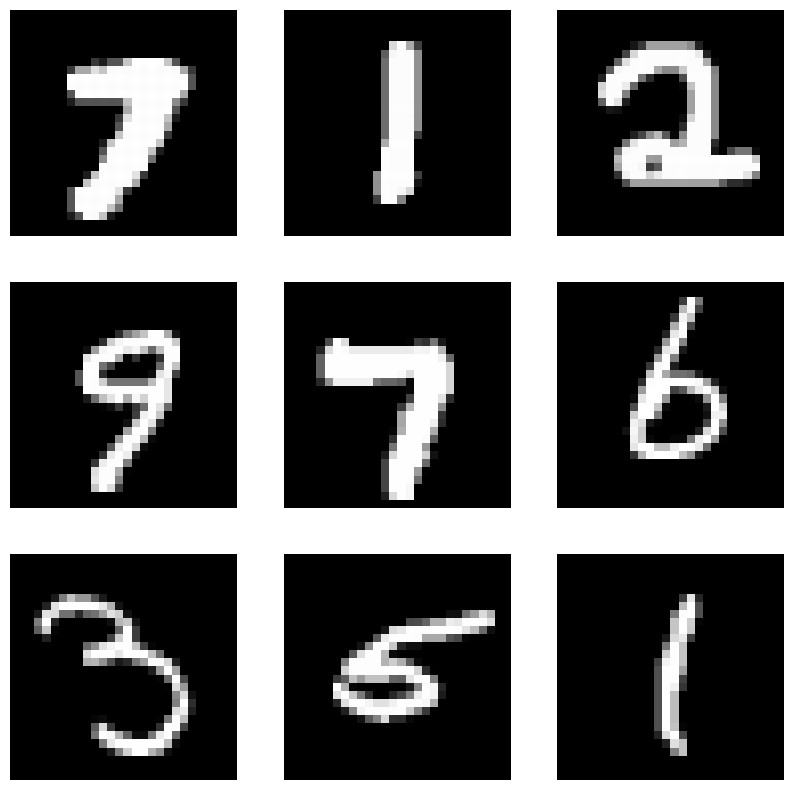

In [2]:
from keras.datasets import mnist

# load dataset
(train_data, y_train),(test_data, y_test) = mnist.load_data()

# keep 10k images for train data
train_data = train_data[:10000]

# keep 4k images for test data
test_data = test_data[:4000]

# Print the shape of the data
print(f'Shape of MNIST train images: {train_data.shape}')
print(f'Shape of MNIST test images: {test_data.shape}')

# Display 9 random images in training data
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(train_data[np.random.randint(0, 10000)], cmap='gray')
        ax[i, j].axis('off')
plt.show()


# Data Pre-processing

In [3]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
# check the shape of the data
print(f'Shape of MNIST images: {train_data.shape}')

# convert the data type to float32
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# check the type of the data
print(f'Type of MNIST train images: {train_data.dtype}')
print(f'Type of MNIST test images: {test_data.dtype}')


# normalize the data
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

# check the range of the data
print(f'Range of MNIST test images: {train_data.min()} to {train_data.max()}')
print(f'Range of MNIST train images: {test_data.min()} to {test_data.max()}')

# parition the data into training and validation sets
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                                train_data,
                                                                test_size=0.2)

# print the shape of training data and validation data
print(f'Shape of training data: {train_X.shape}')
print(f'Shape of validation data: {valid_X.shape}')

print(f'Shape of training labels: {train_ground.shape}')
print(f'Shape of validation labels: {valid_ground.shape}')

Shape of MNIST images: (10000, 28, 28, 1)
Type of MNIST train images: float32
Type of MNIST test images: float32
Range of MNIST test images: 0.0 to 1.0
Range of MNIST train images: 0.0 to 1.0
Shape of training data: (8000, 28, 28, 1)
Shape of validation data: (2000, 28, 28, 1)
Shape of training labels: (8000, 28, 28, 1)
Shape of validation labels: (2000, 28, 28, 1)


# The Convolutional Autoencoder

In [4]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))

In [5]:
# Latent dimension (change the size as needed)
latent_dim = 28

def encoder(input_img):
    # Encoder layers
    conv1 = Conv2D(32, (7, 7), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (7, 7), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (7, 7), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)

    # create a flattened layer
    flat = Flatten()(conv3)
    # print the shape of the flattened layer
    print(f'Shape of flattened layer: {flat.shape}')

    # create a bottleneck layer
    bottleneck = Dense(latent_dim, activation='relu')(flat)

    # print the shape of the bottleneck layer
    print(f'Shape of bottleneck layer: {bottleneck.shape}')

    return bottleneck

# Define the decoder function
def decoder(bottleneck):
    reshape_bottleneck = Dense(7 * 7 * 128, activation='relu')(bottleneck)
    reshape_bottleneck = Reshape((7, 7, 128))(reshape_bottleneck)

    conv4 = Conv2D(128, (7, 7), activation='relu', padding='same')(reshape_bottleneck)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, (7, 7), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2, 2))(conv5)
    conv6 = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(up2)

    return conv6

# Input layer
input_img = Input(shape=(28, 28, 1))

# Create the encoder and models
encoder_model = Model(input_img, encoder(input_img))

# autoencoder model
autoencoder_model = Model(input_img, decoder(encoder(input_img)))

# decoder model
decoder_input = Input(shape=(latent_dim,))
decoder_output = decoder(decoder_input)
decoder_model = Model(decoder_input, decoder_output)

# Compile the autoencoder model (not necessary for the decoder only model)
encoder_model.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))
autoencoder_model.compile(loss='mean_squared_error', optimizer=RMSprop(0.01))

# Print model summaries
encoder_model.summary()
autoencoder_model.summary()

2024-01-02 17:14:50.636082: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Shape of flattened layer: (None, 6272)
Shape of bottleneck layer: (None, 28)
Shape of flattened layer: (None, 6272)
Shape of bottleneck layer: (None, 28)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        1600      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14,

# Train the model

In [6]:
autoencoder_train = autoencoder_model.fit(train_X, train_ground, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/10
 9/63 [===>..........................] - ETA: 1:22 - loss: 0.2249

KeyboardInterrupt: 

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, '-r', label='Training loss')
plt.plot(epochs, val_loss, '-g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the Model

In [ ]:
# Save the models
autoencoder_model.save('autoencoder.h5')
encoder_model.save('encoder.h5')
decoder_model.save('decoder.h5')  # Save the decoder model separately

# Predict the autoencoder output from test images
pred = autoencoder_model.predict(test_data)

# Predict the encoder output from test images
encoded_data = encoder_model.predict(test_data)

# Generate 10 random indices
random_indices = np.random.choice(test_data.shape[0], size=10, replace=False)

for j in range(10):
    index = random_indices[j]
    print(
        f'=========================================================== Image {j+1} ===========================================================')

    # Display the original image in a separate plot
    fig_original, ax_original = plt.subplots(figsize=(2, 2))
    ax_original.imshow(test_data[index, :, :, 0], cmap='gray')
    ax_original.set_title('Original')
    ax_original.get_xaxis().set_visible(False)
    ax_original.get_yaxis().set_visible(False)
    plt.show()

    # Display the image after reconstruction
    fig_reconstructed, ax_reconstructed = plt.subplots(figsize=(2, 2))
    ax_reconstructed.imshow(pred[index, :, :, 0], cmap='gray')
    ax_reconstructed.set_title('Reconstructed')
    ax_reconstructed.get_xaxis().set_visible(False)
    ax_reconstructed.get_yaxis().set_visible(False)
    plt.show()

    # Obtain encoded representation using the encoder model
    encoded_representation = encoder_model.predict(test_data[index:index + 1])
    
    # Display the encoded representation
    print(f'Encoded Representation Shape: {encoded_representation.shape}')

    # Obtain decoded representation using the decoder model
    decoded_representation = decoder_model.predict(encoded_representation)
    
    # Display the decoded representation
    fig_decoded, ax_decoded = plt.subplots(figsize=(2, 2))
    ax_decoded.imshow(decoded_representation[0, :, :, 0], cmap='gray')
    ax_decoded.set_title('Decoded')
    ax_decoded.get_xaxis().set_visible(False)
    ax_decoded.get_yaxis().set_visible(False)
    plt.show()